 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 7. Neural Network Improvements**
# Section 4. Mini-Batch SGD

### _Objective_
1. 딥러닝에서 경사하강법 중 가장 많이 쓰이는 Mini-Batch SGD에 대해 배워보도록 하겠습니다. <br>
2. Mini-Batch로도 학습이 어떻게 가능한지를 알아보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [3]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

np.random.seed(30)
tf.random.set_random_seed(30)

# Tensorboard 추가하기
!pip install tensorboardcolab
import tensorboardcolab

LOG_DIR = "./logs/" # Tensorboard 로그 폴더 위치
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [4]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 관계에 대한 데이터 셋입니다. <br>
아래와 같이 랜덤으로 2000개의 데이터셋을 만들었습니다.

In [5]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 2000) # 5% ~ 90% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.normal(0,0.01) 
           for x in invests]) # 예상 수익률

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 1400
test 데이터셋 크기 : 600


### 데이터 시각화

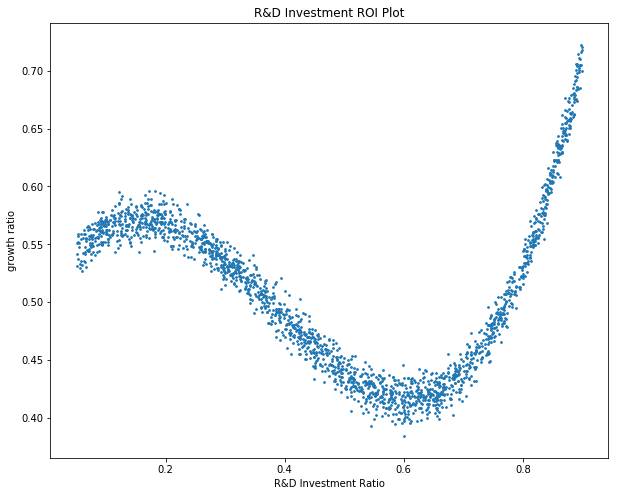

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(invests, growths, s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

<br><br>

# \[ 1. Tensorflow Graph 그리기 \]

----

----

> *3층짜리 신경망을 구성해보도록 하겠습니다.* <br>
> *구성한 신경망을 통해 배치 사이즈에 따라 Learning Curve가 어떤 식으로 바뀌는지 확인해 보도록 하겠습니다.* <br>

In [7]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_hidden1, activation=tf.nn.relu,
                               kernel_initializer=he_init, name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_hidden2, activation=tf.nn.relu, 
                               kernel_initializer=he_init, name='hidden_2')
    y_pred = tf.layers.dense(hidden_2, 1,
                            kernel_initializer=xavier_init, name='output')
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.scalar("rmse", rmse)
    tf.summary.scalar("loss", loss)
    
    # training operation
    train_op = (tf.train
                .GradientDescentOptimizer(learning_rate=0.01)
                .minimize(loss))


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [8]:
show_graph(graph)

<br><br>

# \[ 2. 배치 사이즈에 따른 학습 곡선 비교 \]

----

----

> *Batch GD VS SGD VS Mini-Batch SGD로 나누어, 어떤 식의 차이가 있는지 관찰해보도록 하겠습니다.* <br>

<br>
## 1. Batch GD
---

* Batch GD는 Deterministic GD라고도 불립니다.<br>
* 매 학습 때마다 동일한 데이터를 가지고 경사하강법을 통해 학습하기 때문입니다.<br>
* 안정적으로 학습되나, 느리다는 단점이 존재합니다. <br>

 0th epoch RMSE : 0.274
1000th epoch RMSE : 0.068
2000th epoch RMSE : 0.068
3000th epoch RMSE : 0.067
4000th epoch RMSE : 0.066
5000th epoch RMSE : 0.065
6000th epoch RMSE : 0.064
7000th epoch RMSE : 0.062
8000th epoch RMSE : 0.060
9000th epoch RMSE : 0.056
10000th epoch RMSE : 0.051
11000th epoch RMSE : 0.047
12000th epoch RMSE : 0.044
13000th epoch RMSE : 0.040
14000th epoch RMSE : 0.037
15000th epoch RMSE : 0.034
16000th epoch RMSE : 0.032
17000th epoch RMSE : 0.029
18000th epoch RMSE : 0.028
19000th epoch RMSE : 0.026
20000th epoch RMSE : 0.024
21000th epoch RMSE : 0.023
22000th epoch RMSE : 0.022
23000th epoch RMSE : 0.021
24000th epoch RMSE : 0.020
25000th epoch RMSE : 0.020
26000th epoch RMSE : 0.019
27000th epoch RMSE : 0.019
학습 총 소요 시간 ---- 59.944s


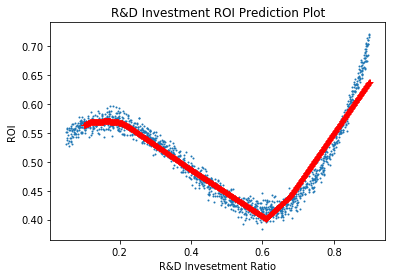

In [9]:
# 학습
num_step = 28000 # 학습 횟수

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"batch_GD/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"batch_GD/test/")
    
    for epoch in range(num_step):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        if epoch % 50 == 0:
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 1000 == 0:
                print("{:2d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
                
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r--')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

<br>
## 2. SGD(stochastic Gradient Descent)
---

* SGD는 확률적 경사 하강법으로, 데이터셋 중 하나씩 추출하여 학습시키는 방법을 의미합니다. <br>
* 매 학습 때마다 다른 데이터를 가지고 경사하강법을 통해 학습하기 때문에, Loss값이 진동하면서 떨어집니다..<br>
* 불안정적으로 학습되지만, 빠르게 계산할 수 있다는 장점이 존재합니다. <br>

    0 epoch RMSE : 0.094
    1 epoch RMSE : 0.087
    2 epoch RMSE : 0.079
    3 epoch RMSE : 0.071
    4 epoch RMSE : 0.063
    5 epoch RMSE : 0.056
    6 epoch RMSE : 0.051
    7 epoch RMSE : 0.047
    8 epoch RMSE : 0.044
    9 epoch RMSE : 0.040
   10 epoch RMSE : 0.037
   11 epoch RMSE : 0.035
   12 epoch RMSE : 0.032
   13 epoch RMSE : 0.030
   14 epoch RMSE : 0.028
   15 epoch RMSE : 0.026
   16 epoch RMSE : 0.024
   17 epoch RMSE : 0.023
   18 epoch RMSE : 0.022
   19 epoch RMSE : 0.021
학습 총 소요 시간 ---- 11.419s


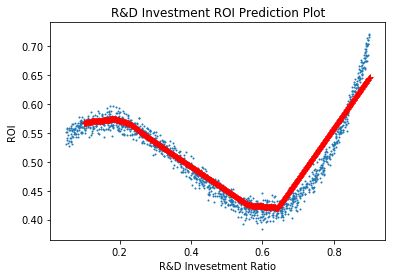

In [10]:
# 학습
num_step = len(train_invests) # 1 Epoch 당 학습 횟수
n_epoch = 28000 // num_step # batch Gradient Descent와 같이, 동일하게 함

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"SGD/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"SGD/test/")
    
    global_step = 0
    for epoch in range(n_epoch):
        for step in range(num_step):
            # 학습
            global_step += 1
            sess.run(train_op,feed_dict={X:train_invests[step:step+1],
                                         y:train_growths[step:step+1]})

            if step % 100 == 0:
                ## Train 
                summary_str = sess.run(summary_op, feed_dict={
                    X: train_invests, y:train_growths})
                train_writer.add_summary(summary_str,
                                         global_step=global_step)

                ## Test
                summary_str,rmse_value = sess.run([summary_op,rmse], 
                              feed_dict={X: test_invests, y:test_growths})
                test_writer.add_summary(summary_str, 
                                        global_step=global_step)                
        print(f"{epoch:5d} epoch RMSE : {rmse_value:2.3f}")
            
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r--')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

<br>
## 2. Mini-Batch SGD(stochastic Gradient Descent)
---

* Mini-Batch SGD는 Batch GD와 SGD의 장점을 섞은 방법으로, 1개의 데이터 대신 여러개의 데이터를 추출해 Gradient Descent을 적용하는 방법입니다. <br>
* 일반적으로 가장 많이 쓰는 방식입니다. <br>

    0 epoch step RMSE : 0.303
   10 epoch step RMSE : 0.069
   20 epoch step RMSE : 0.068
   30 epoch step RMSE : 0.068
   40 epoch step RMSE : 0.067
   50 epoch step RMSE : 0.067
   60 epoch step RMSE : 0.067
   70 epoch step RMSE : 0.066
   80 epoch step RMSE : 0.065
   90 epoch step RMSE : 0.064
  100 epoch step RMSE : 0.063
  110 epoch step RMSE : 0.060
  120 epoch step RMSE : 0.058
  130 epoch step RMSE : 0.056
  140 epoch step RMSE : 0.054
  150 epoch step RMSE : 0.051
  160 epoch step RMSE : 0.049
  170 epoch step RMSE : 0.046
  180 epoch step RMSE : 0.043
  190 epoch step RMSE : 0.041
  200 epoch step RMSE : 0.039
  210 epoch step RMSE : 0.036
  220 epoch step RMSE : 0.034
  230 epoch step RMSE : 0.033
  240 epoch step RMSE : 0.031
  250 epoch step RMSE : 0.029
  260 epoch step RMSE : 0.028
  270 epoch step RMSE : 0.027
  280 epoch step RMSE : 0.026
  290 epoch step RMSE : 0.025
  300 epoch step RMSE : 0.024
  310 epoch step RMSE : 0.023
  320 epoch step RMSE : 0.022
  330 epoc

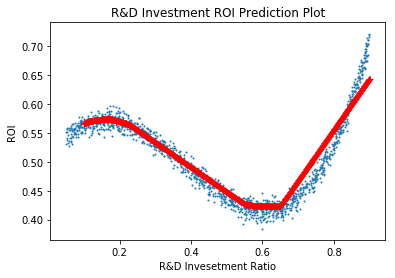

In [11]:
# 학습
batch_size = 10
num_step = len(train_invests) // batch_size
n_epoch = 28000 // num_step

start_time = time.time() # 학습 시작 시간
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"minibatch_SGD/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"minibatch_SGD/test/")
    
    global_step = 0
    for epoch in range(n_epoch):
        for step in range(num_step):
            # 학습
            global_step += 1
            batch_invests = train_invests[step*batch_size:(step+1)*batch_size]
            batch_growths = train_growths[step*batch_size:(step+1)*batch_size]
            sess.run(train_op,
                     feed_dict={X:batch_invests,
                                y:batch_growths})

            if step % 100 == 0:
                ## Train
                summary_str = sess.run(summary_op,
                                       feed_dict={X:train_invests,
                                                  y:train_growths})
                train_writer.add_summary(summary_str,
                                         global_step=global_step)

                ## Test
                summary_str,rmse_value = sess.run([summary_op,rmse], 
                              feed_dict={X:test_invests,
                                         y:test_growths})
                test_writer.add_summary(summary_str, 
                                        global_step=global_step)            
                
        if epoch % 10 == 0:
            print("{:5d} epoch step RMSE : {:2.3f}".format(epoch,rmse_value))
            
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r--')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

<br><br>

# \[ 3. 배치 사이즈에 따른 손실함수 곡선 비교 \]

----

----

> *Mini-Batch의 크기가 커질수록, Full Batch의 손실함수에 근사합니다* <br>
> *Mini-Batch이 커질수록 모델이 보다 안정적으로 학습할 수 있게 됩니다.* <br>

<br>
## 1. 기 학습된 모델 가져오기
---

* 위의 데이터셋으로 동일하게 학습된 모델을 가져옵니다. <br>
* 학습은 랜덤하게 이루어지기 때문에, 동일한 손실함수 곡면을 보기 위해서 미리 학습된 모델을 가져왔습니다.<br>

### (1) 모델 다운로드 받기

In [12]:
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.data-00000-of-00001
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.index
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.meta

--2019-04-05 10:44:13--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.data-00000-of-00001
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.56.73
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.56.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41604 (41K) [binary/octet-stream]
Saving to: ‘model.ckpt.data-00000-of-00001.1’

model.ckpt.data-000 100%[===================>]  40.63K  --.-KB/s    in 0.008s  

2019-04-05 10:44:14 (5.25 MB/s) - ‘model.ckpt.data-00000-of-00001.1’ saved [41604/41604]

--2019-04-05 10:44:14--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/algorithm-ai-basic/lecture-3-sgd/model.ckpt.index
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.56.73
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.56.73|:443... connected.
HTTP request se

### (2) 모델 불러오기

In [13]:
graph = tf.Graph()
with graph.as_default():
    sess = tf.Session()
    saver = tf.train.import_meta_graph("./model.ckpt.meta")
    saver.restore(sess, "./model.ckpt")
    
    X = graph.get_tensor_by_name('X:0')
    y = graph.get_tensor_by_name('y:0')
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0]
    
    # Weight 하나 가져오기
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    variable = variables[0]    
    print("가져오는 variable :", variable)
    original_kernel = variable.eval(sess)

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./model.ckpt


INFO:tensorflow:Restoring parameters from ./model.ckpt


가져오는 variable : <tf.Variable 'hidden_1/kernel:0' shape=(1, 100) dtype=float32_ref>


In [ ]:
show_graph(graph)

### (3) 해당 모델 내 weight 한개의 손실 함수

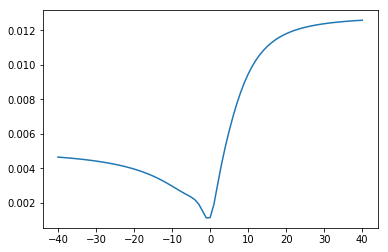

In [14]:
# Weight에 -40~40까지 순차적으로 넣어 보자
xs = np.linspace(-40,40,81)

kernel = original_kernel.copy()
ys = []
for x in xs:
    kernel[0,34] = x # 은닉층 중 한개의 Weight 값 바꾸기
    update_kernel = variable.assign(kernel)
    sess.run(update_kernel)

    result = sess.run(loss,feed_dict={X:train_invests,
                                      y:train_growths})

    ys.append(result)

plt.plot(xs,ys)
plt.show()

<br>

## 2. Batch GD, SGD, mini-Batch SGD의 손실 그래프 비교하기
---

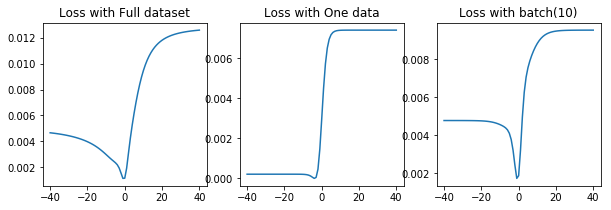

In [15]:
# Weight에 -40~40까지 바꿔가면서 넣어보자
xs = np.linspace(-40,40,81)
kernel = original_kernel.copy()

ys_with_full = []
ys_with_batch = []
ys_with_one = []
for x in xs:
    kernel[0,34] = x
    update_kernel = variable.assign(kernel)
    sess.run(update_kernel)

    loss_with_full = sess.run(loss,feed_dict={X:train_invests,
                                          y:train_growths})
    loss_with_batch = sess.run(loss,feed_dict={X:train_invests[0:10],
                                          y:train_growths[0:10]})
    loss_with_one = sess.run(loss,feed_dict={X:train_invests[0:1],
                                          y:train_growths[0:1]})
    ys_with_full.append(loss_with_full)
    ys_with_batch.append(loss_with_batch)
    ys_with_one.append(loss_with_one)

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,3,1)
ax.plot(xs,ys_with_full)
ax.set_title("Loss with Full dataset")
ax = fig.add_subplot(1,3,2)
ax.plot(xs,ys_with_one)
ax.set_title("Loss with One data")
ax = fig.add_subplot(1,3,3)
ax.plot(xs,ys_with_batch)
ax.set_title("Loss with batch(10)")
plt.show()

<br>

## 3. Batch 사이즈 별 손실 그래프 비교하기
---


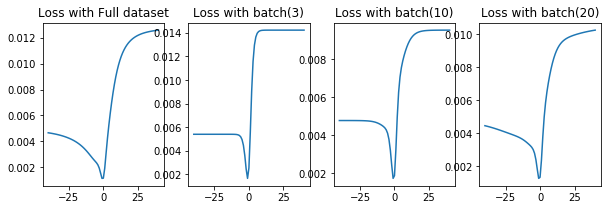

In [16]:
# Weight에 -40~40까지 바꿔가면서 넣어보자
xs = np.linspace(-40,40,81)
kernel = original_kernel.copy()

ys_with_full = []
ys_with_3 = []
ys_with_10 = []
ys_with_20 = []
ys_with_80 = []
for x in xs:
    kernel[0,34] = x
    update_kernel = variable.assign(kernel)
    sess.run(update_kernel)

    loss_with_full = sess.run(loss,feed_dict={X:train_invests,
                                          y:train_growths})
    loss_with_3 = sess.run(loss,feed_dict={X:train_invests[0:3],
                                          y:train_growths[0:3]})
    loss_with_10 = sess.run(loss,feed_dict={X:train_invests[0:10],
                                          y:train_growths[0:10]})
    loss_with_20 = sess.run(loss,feed_dict={X:train_invests[0:20],
                                          y:train_growths[0:20]})
    loss_with_80 = sess.run(loss,feed_dict={X:train_invests[0:80],
                                          y:train_growths[0:80]})
    

    ys_with_full.append(loss_with_full)
    ys_with_3.append(loss_with_3)
    ys_with_10.append(loss_with_10)
    ys_with_20.append(loss_with_20)
    ys_with_80.append(loss_with_80)    

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,5,1)
ax.plot(xs,ys_with_full)
ax.set_title("Loss with Full dataset")
ax = fig.add_subplot(1,5,2)
ax.plot(xs,ys_with_3)
ax.set_title("Loss with batch(3)")
ax = fig.add_subplot(1,5,3)
ax.plot(xs,ys_with_10)
ax.set_title("Loss with batch(10)")
ax = fig.add_subplot(1,5,4)
ax.plot(xs,ys_with_20)
ax.set_title("Loss with batch(20)")
ax = fig.add_subplot(1,5,5)
ax.plot(xs,ys_with_40)
ax.set_title("Loss with batch(80)")
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---